In [1]:
import os
print(os.getcwd())

import sys
sys.path.append('../Utilities/src')
from DA_tools.DA_colors2 import *


import scipy.stats as stats
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
import pandas as pd


import matplotlib as mpl
plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200


from numpy.random import normal,standard_t
from scipy.special import expit,logit
from svgpathtools import Path, Line, CubicBezier, wsvg
from cmdstanpy import CmdStanModel


/Users/jerzybaranowski/GitHub/KAIR-ISZ/bayes_book/bayes_book/notebooks


# Hamiltonian Monte Carlo

In [3]:
model = CmdStanModel(stan_file='../stan_files/normal.stan')

INFO:cmdstanpy:compiling stan file /Users/jerzybaranowski/GitHub/KAIR-ISZ/bayes_book/bayes_book/stan_files/normal.stan to exe file /Users/jerzybaranowski/GitHub/KAIR-ISZ/bayes_book/bayes_book/stan_files/normal
INFO:cmdstanpy:compiled model executable: /Users/jerzybaranowski/GitHub/KAIR-ISZ/bayes_book/bayes_book/stan_files/normal


In [8]:
result = model.sample()

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [33]:
result2 = model.sample(save_warmup=True,thin=10,output_dir='')


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [17]:
mc_series = result.draws_pd()[['q_1','q_2']]
N=len(mc_series)
series_mcse = lambda series: az.mcse(series.values)
expan_mean_1 = mc_series.q_1.expanding().mean()
expan_std_1 = mc_series.q_1.expanding().apply(series_mcse)
expan_mean_2 = mc_series.q_2.expanding().mean()
expan_std_2 = mc_series.q_2.expanding().apply(series_mcse)

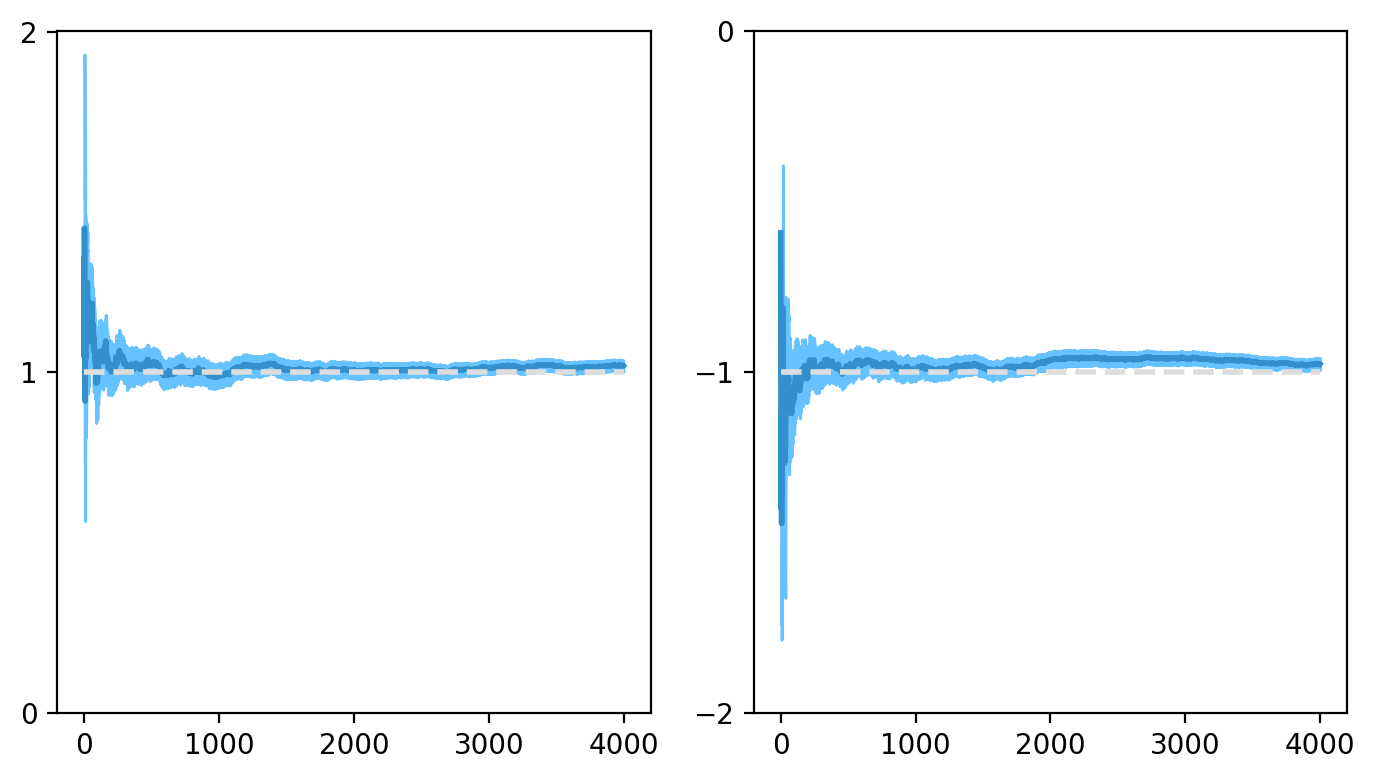

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (7,4))

ax1.plot(expan_mean_1,color=MID_HIGHLIGHT,linewidth=2)
ax1.plot([0,N],[1,1],color=LIGHT_GREY,linestyle = '--',linewidth=2)

ax1.fill_between([*range(N)],expan_mean_1-expan_std_1,expan_mean_1+expan_std_1,color=MID)

ax2.plot(expan_mean_2,color=MID_HIGHLIGHT,linewidth=2)
ax2.fill_between([*range(N)],expan_mean_2-expan_std_2,expan_mean_2+expan_std_2,color=MID)
ax2.plot([0,N],[-1,-1],color=LIGHT_GREY,linestyle = '--',linewidth=2)

ax1.set_yticks([0,1,2])
ax2.set_yticks([-2,-1,0])

plt.tight_layout()

In [23]:
target_lpdf = lambda q:   - 0.5 * ( (q[0] - 1)**2 + (q[1] + 1)**2 ) - 0.5 * 2 * np.log(6.283185307179586)


q_1=np.linspace(-2,4,600)
q_2=np.linspace(-4,2,600)
Q1,Q2 = np.meshgrid(q_1,q_2)
Z = np.zeros(Q1.shape)
for i in range(600):
    for j in range(600):
        Z[i,j]=np.exp(target_lpdf((Q1[i,j],Q2[i,j])))


In [42]:
draws = result2.draws(inc_warmup=True)

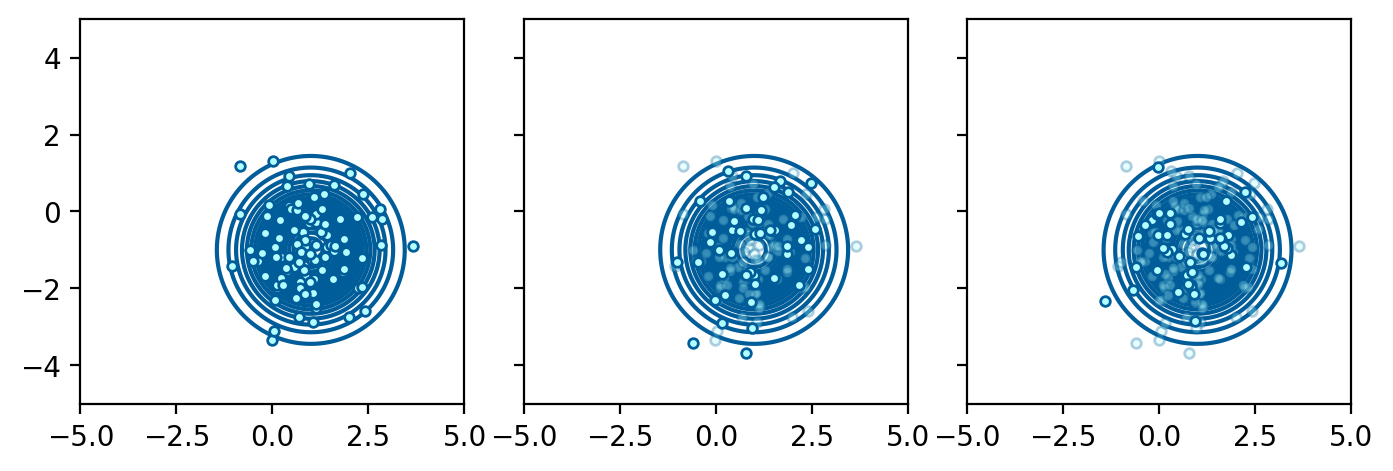

In [53]:
q1 = draws[:,0,7]
q2 = draws[:,0,8]

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = [7,4],tight_layout=True,sharey=True)
ax1.contour(Q1,Q2,Z,levels=25,colors=DARK,zorder=0)
ax1.scatter(q1[:101],q2[:101],ec=DARK,fc=LIGHT,s=12,zorder=1)
ax1.set_ylim(-5,5)
ax1.set_xlim(-5,5)

ax1.set_aspect('equal')
ax2.contour(Q1,Q2,Z,levels=25,colors=DARK,zorder=0)
ax2.scatter(q1[:101],q2[:101],ec=DARK,fc=LIGHT,s=12,alpha=0.3,zorder=1)
ax2.scatter(q1[101:151],q2[101:151],ec=DARK,fc=LIGHT,s=12,zorder=2)
ax2.set_ylim(-5,5)
ax2.set_xlim(-5,5)
ax2.set_aspect('equal')
ax3.contour(Q1,Q2,Z,levels=25,colors=DARK,zorder=0)
ax3.scatter(q1[:151],q2[:151],ec=DARK,fc=LIGHT,s=12,alpha=0.3,zorder=1)
ax3.scatter(q1[151:],q2[151:],ec=DARK,fc=LIGHT,s=12,zorder=2)
ax3.set_ylim(-5,5)
ax3.set_xlim(-5,5)
ax3.set_aspect('equal')

In [54]:
def target_lpdf2(q):
    D = len(q)
    lpdf = - 0.5 * q[0]**2 - 0.5 * np.log(6.283185307179586)
    lpdf = lpdf - 0.5 * (q[1] / 5)**2 - 0.5 * np.log(6.283185307179586 * 25)
    for d in range(2,D):
        lpdf = lpdf - 0.5 * ((q[d] - q[0]) / np.exp(q[1]))**2
        lpdf = lpdf - 0.5 * np.log(6.283185307179586) - q[1]
    return lpdf

In [55]:
q_2=np.linspace(-10,2,1000)
q_3=np.linspace(-11,11,1000)
Q2,Q3 = np.meshgrid(q_2,q_3)
Z = np.zeros(Q2.shape)
for i in range(1000):
    for j in range(1000):
        q=[0, q_2[j],q_3[i], 0, 0, 0, 0, 0, 0, 0, 0, 0]
        Z[i,j]=np.exp(target_lpdf2(q))

In [103]:
model_fun = CmdStanModel(stan_file='../stan_files/funnel_72.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [106]:
result_fun = model_fun.sample(data={'D':12},output_dir='')

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)





chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [107]:
result_fun.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-67.000,11.000,28.0,-110.0,-65.0000,-21.0,6.2,2.6,1.5
mu,0.063,0.038,1.0,-1.6,0.0017,1.8,690.0,290.0,1.0
log_tau,6.000,1.100,2.7,1.5,5.8000,10.0,6.3,2.6,1.4
theta[1],353.000,1102.000,11654.0,-9874.0,3.8000,11248.0,112.0,46.0,1.0
theta[2],-1696.000,2380.000,13147.0,-21972.0,-1.2000,7334.0,31.0,13.0,1.2
theta[3],-1265.000,2302.000,14265.0,-25702.0,-1.9000,7571.0,38.0,16.0,1.1
theta[4],436.000,562.000,9569.0,-10109.0,0.2400,11585.0,290.0,119.0,1.0
theta[5],708.000,1153.000,10745.0,-8549.0,0.7500,12858.0,87.0,36.0,1.0
theta[6],-305.000,1457.000,13095.0,-10870.0,-0.4400,13165.0,81.0,33.0,1.0


In [109]:
print(result_fun.diagnose())

Processing csv files: /Users/jerzybaranowski/GitHub/KAIR-ISZ/bayes_book/bayes_book/notebooks/funnel_72-20220408062703_1.csv, /Users/jerzybaranowski/GitHub/KAIR-ISZ/bayes_book/bayes_book/notebooks/funnel_72-20220408062703_2.csv, /Users/jerzybaranowski/GitHub/KAIR-ISZ/bayes_book/bayes_book/notebooks/funnel_72-20220408062703_3.csv, /Users/jerzybaranowski/GitHub/KAIR-ISZ/bayes_book/bayes_book/notebooks/funnel_72-20220408062703_4.csv

Checking sampler transitions treedepth.
816 of 4000 (20.40%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
32 of 4000 (0.80%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, tr

array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'log_tau'}>,
        <AxesSubplot:title={'center':'log_tau'}>],
       [<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

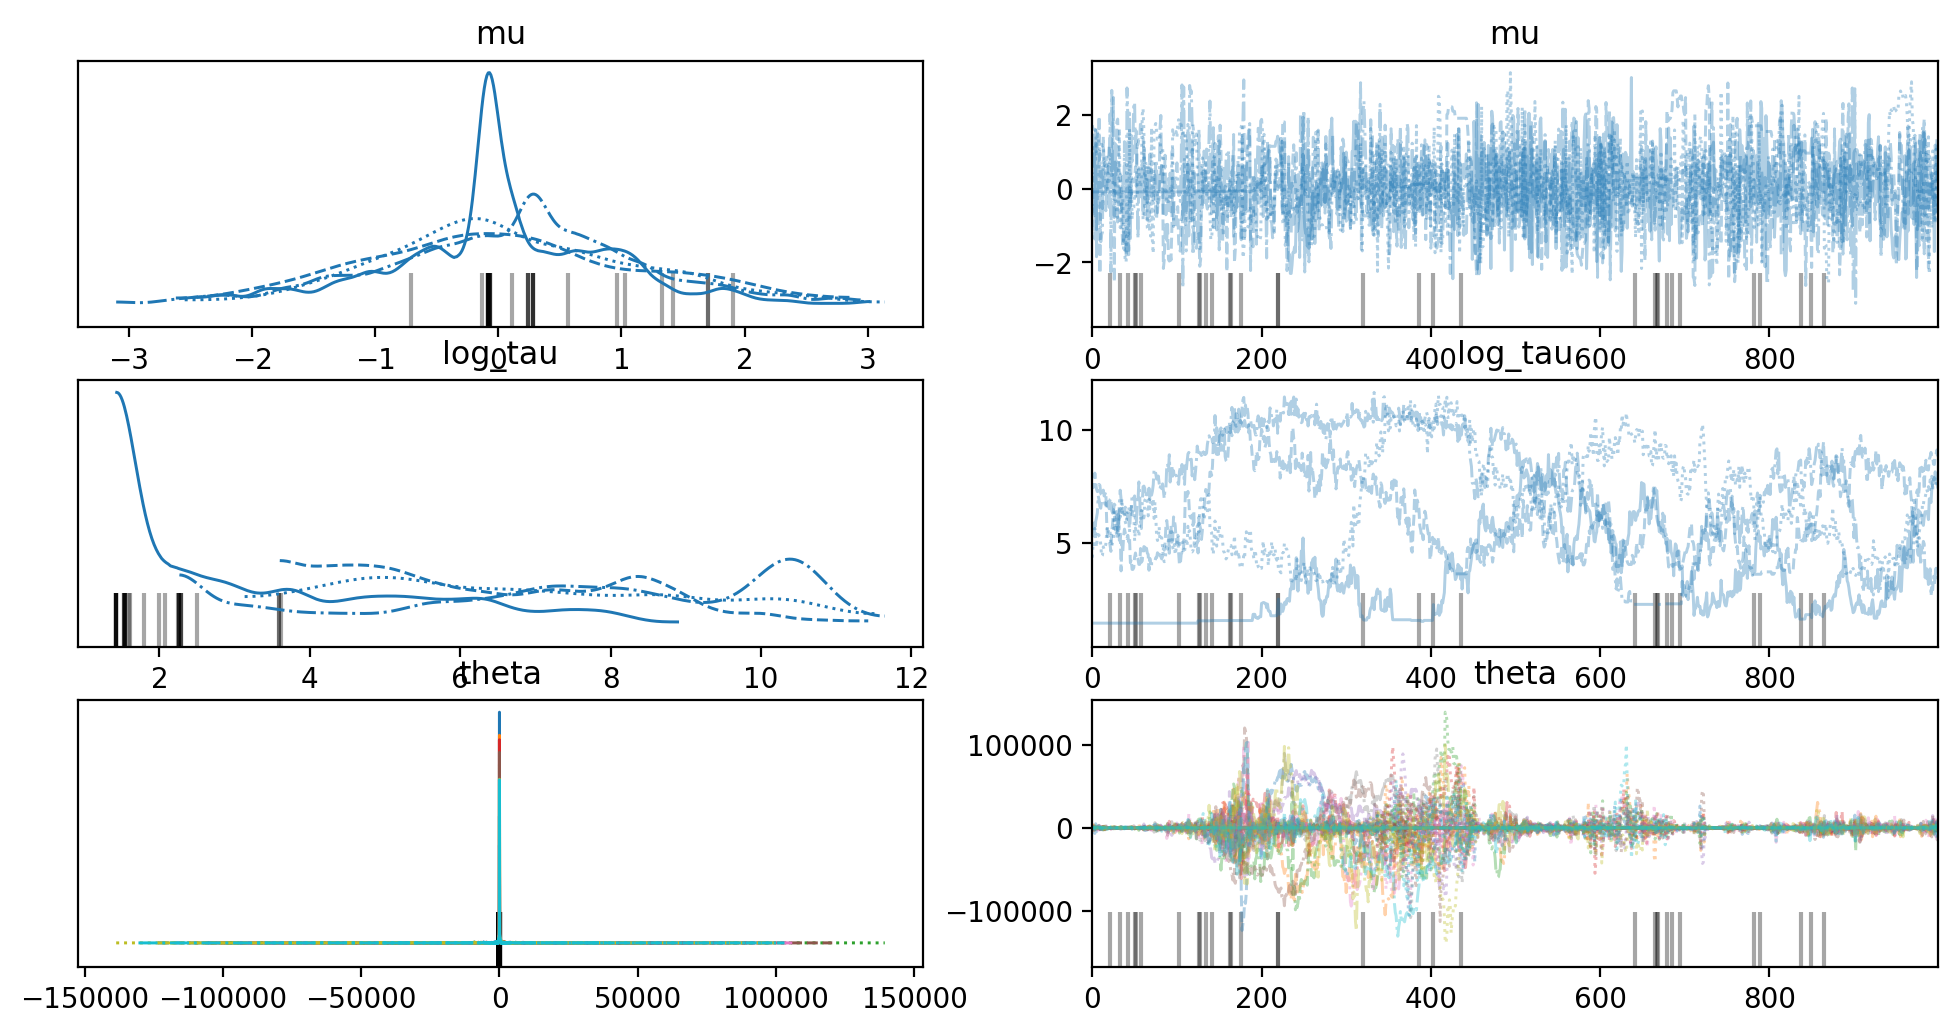

In [121]:
az.plot_trace(result_fun)

In [110]:
result_fun2 = model_fun.sample({'D':12},save_warmup=True)


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


(-11.0, 11.0)

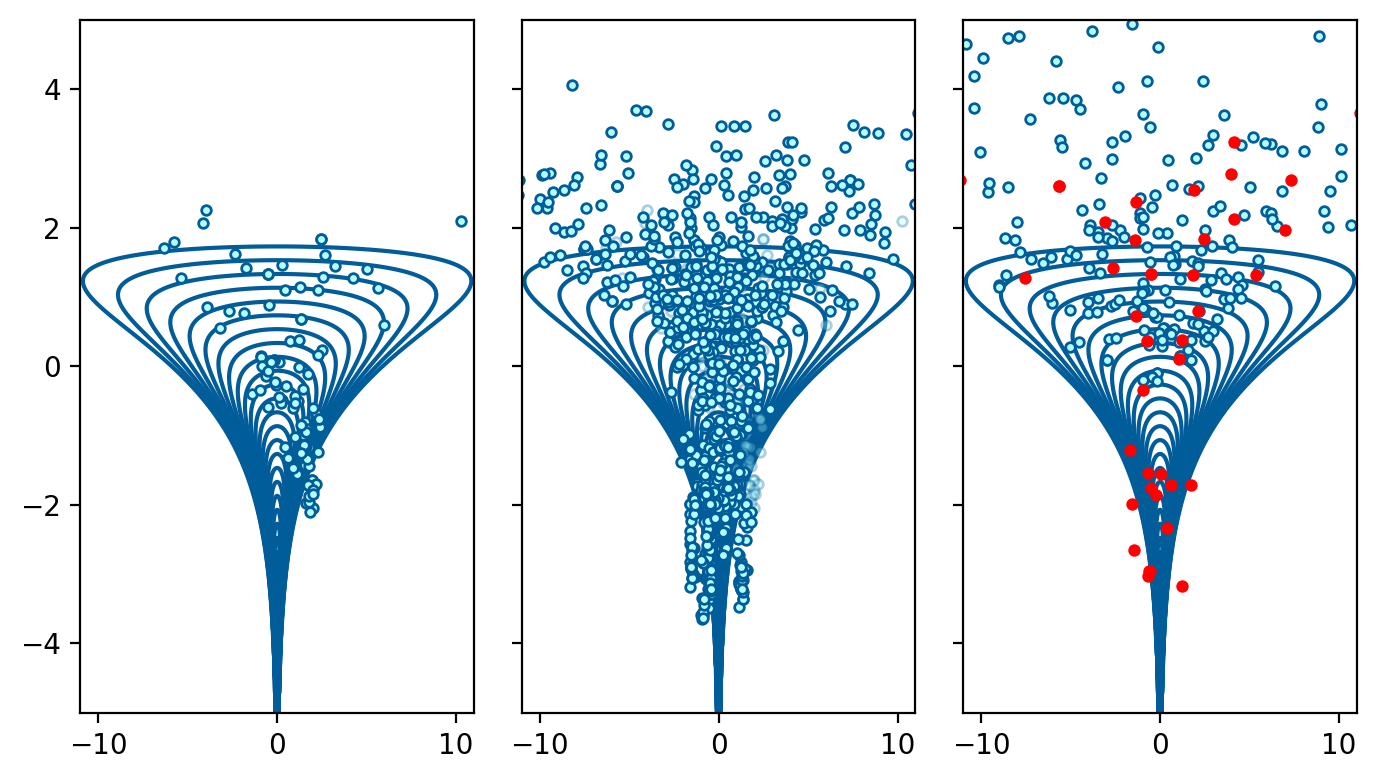

In [111]:
mcmc_samples = result_fun2.draws(inc_warmup=True)[:,1,:]
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = [7,4],tight_layout=True,sharey=True)
ax1.contour(Q3,Q2,Z,levels=np.exp([*range(-30,90,2)]),colors=DARK,zorder=0)
ax1.scatter(mcmc_samples[:101,-10],mcmc_samples[:101,-11],ec=DARK,fc=LIGHT,s=12,zorder=1)
ax1.set_ylim(-5,5)
ax1.set_xlim(-11,11)

#ax1.set_aspect('equal')
ax2.contour(Q3,Q2,Z,levels=np.exp([*range(-30,90,2)]),colors=DARK,zorder=0)
ax2.scatter(mcmc_samples[:101,-10],mcmc_samples[:101,-11],ec=DARK,fc=LIGHT,s=12,alpha=0.3,zorder=1)
ax2.scatter(mcmc_samples[101:1001,-10],mcmc_samples[101:1001,-11],ec=DARK,fc=LIGHT,s=12,zorder=2)
ax2.set_ylim(-5,5)
ax2.set_xlim(-11,11)
#ax2.set_aspect('equal')
ax3.contour(Q3,Q2,Z,levels=np.exp([*range(-30,90,2)]),colors=DARK,zorder=0)
#ax3.scatter(mcmc_samples[:1001,-10],mcmc_samples[:1001,-11],ec=DARK,fc=LIGHT,s=12,alpha=0.3,zorder=1)
ax3.scatter(mcmc_samples[1001:,-10],mcmc_samples[1001:,-11],ec=DARK,fc=LIGHT,s=12,zorder=2)
ax3.scatter(mcmc_samples[mcmc_samples[:,5]==1,-10],mcmc_samples[mcmc_samples[:,5]==1,-11],ec='red',fc='red',s=12,zorder=2)
ax3.set_ylim(-5,5)
ax3.set_xlim(-11,11)
#ax3.set_aspect('equal')

In [112]:
model_fun_ncp = CmdStanModel(stan_file='../stan_files/funnel_72_ncp.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [113]:
result_fun_ncp = model_fun_ncp.sample(data={'D':12},output_dir='')

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [114]:
print(result_fun_ncp.diagnose())

Processing csv files: /Users/jerzybaranowski/GitHub/KAIR-ISZ/bayes_book/bayes_book/notebooks/funnel_72_ncp-20220408062840_1.csv, /Users/jerzybaranowski/GitHub/KAIR-ISZ/bayes_book/bayes_book/notebooks/funnel_72_ncp-20220408062840_2.csv, /Users/jerzybaranowski/GitHub/KAIR-ISZ/bayes_book/bayes_book/notebooks/funnel_72_ncp-20220408062840_3.csv, /Users/jerzybaranowski/GitHub/KAIR-ISZ/bayes_book/bayes_book/notebooks/funnel_72_ncp-20220408062840_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [115]:
result_fun_ncp.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-6.1000,0.062,2.50,-11.0,-5.7000,-2.6,1600.0,11000.0,1.0
mu,-0.0052,0.010,1.00,-1.7,-0.0170,1.6,9700.0,67000.0,1.0
log_tau,-0.0130,0.056,4.90,-8.0,0.0480,8.1,7700.0,53000.0,1.0
eta[1],0.0120,0.011,1.00,-1.7,-0.0031,1.6,8290.0,56781.0,1.0
eta[2],-0.0065,0.011,1.00,-1.7,-0.0089,1.7,8772.0,60084.0,1.0
eta[3],-0.0050,0.010,1.00,-1.7,-0.0230,1.7,9548.0,65395.0,1.0
eta[4],-0.0079,0.011,1.00,-1.7,-0.0088,1.6,8473.0,58034.0,1.0
eta[5],-0.0120,0.011,0.99,-1.7,-0.0034,1.6,8692.0,59533.0,1.0
eta[6],-0.0041,0.010,1.00,-1.7,-0.0015,1.7,9855.0,67498.0,1.0


In [116]:
result_fun_ncp2 = model_fun_ncp.sample(data={'D':12})

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


(-11.0, 11.0)

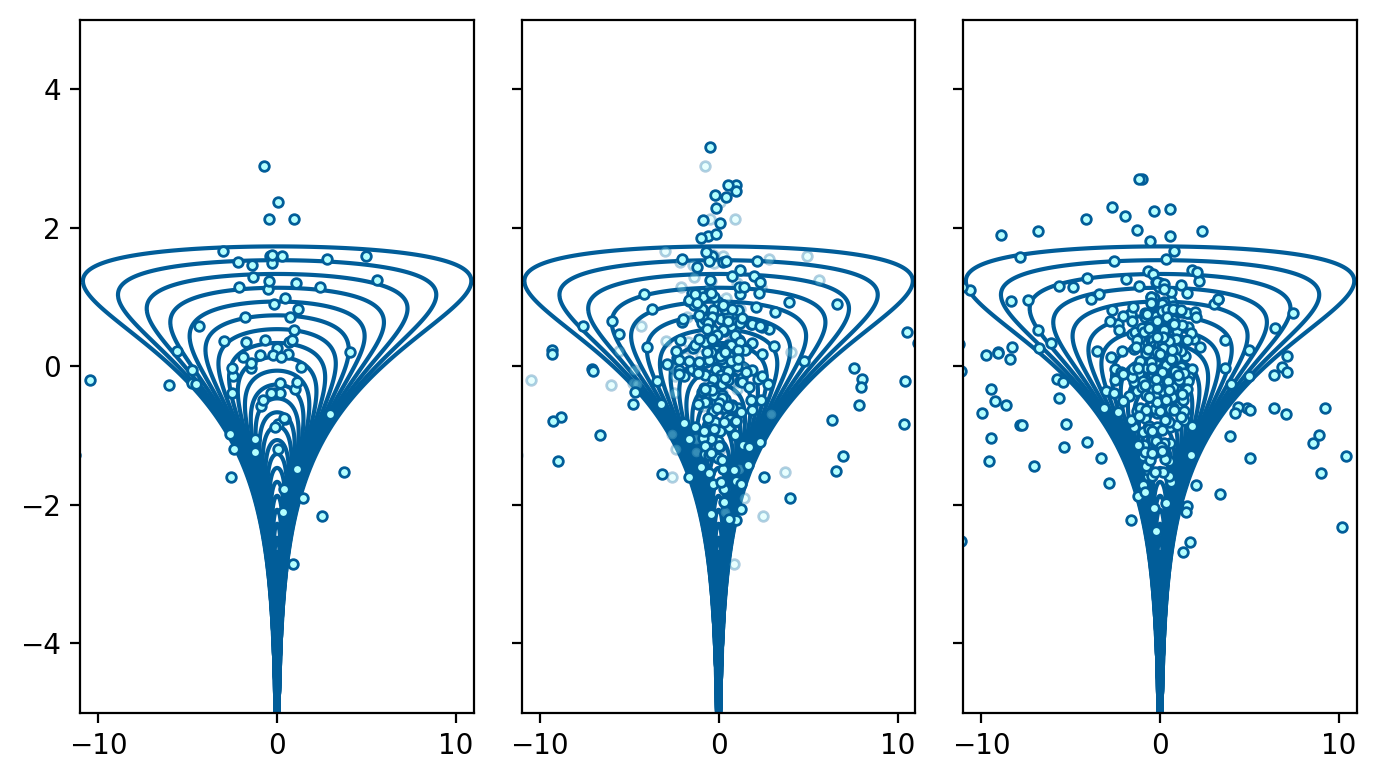

In [120]:
mcmc_samples = result_fun_ncp2.draws(inc_warmup=False)[:,1,:]
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = [7,4],tight_layout=True,sharey=True)
ax1.contour(Q3,Q2,Z,levels=np.exp([*range(-30,90,2)]),colors=DARK,zorder=0)
ax1.scatter(mcmc_samples[:101,-10],mcmc_samples[:101,-11],ec=DARK,fc=LIGHT,s=12,zorder=1)
ax1.set_ylim(-5,5)
ax1.set_xlim(-11,11)

#ax1.set_aspect('equal')
ax2.contour(Q3,Q2,Z,levels=np.exp([*range(-30,90,2)]),colors=DARK,zorder=0)
ax2.scatter(mcmc_samples[:101,-10],mcmc_samples[:101,-11],ec=DARK,fc=LIGHT,s=12,alpha=0.3,zorder=1)
ax2.scatter(mcmc_samples[101:501,-10],mcmc_samples[101:501,-11],ec=DARK,fc=LIGHT,s=12,zorder=2)
ax2.set_ylim(-5,5)
ax2.set_xlim(-11,11)
#ax2.set_aspect('equal')
ax3.contour(Q3,Q2,Z,levels=np.exp([*range(-30,90,2)]),colors=DARK,zorder=0)
#ax3.scatter(mcmc_samples[:1001,-10],mcmc_samples[:1001,-11],ec=DARK,fc=LIGHT,s=12,alpha=0.3,zorder=1)
ax3.scatter(mcmc_samples[501:,-10],mcmc_samples[501:,-11],ec=DARK,fc=LIGHT,s=12,zorder=2)
ax3.scatter(mcmc_samples[mcmc_samples[:,5]==1,-10],mcmc_samples[mcmc_samples[:,5]==1,-11],ec='red',fc='red',s=12,zorder=2)
ax3.set_ylim(-5,5)
ax3.set_xlim(-11,11)
#ax3.set_aspect('equal')

array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'log_tau'}>,
        <AxesSubplot:title={'center':'log_tau'}>],
       [<AxesSubplot:title={'center':'eta'}>,
        <AxesSubplot:title={'center':'eta'}>],
       [<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

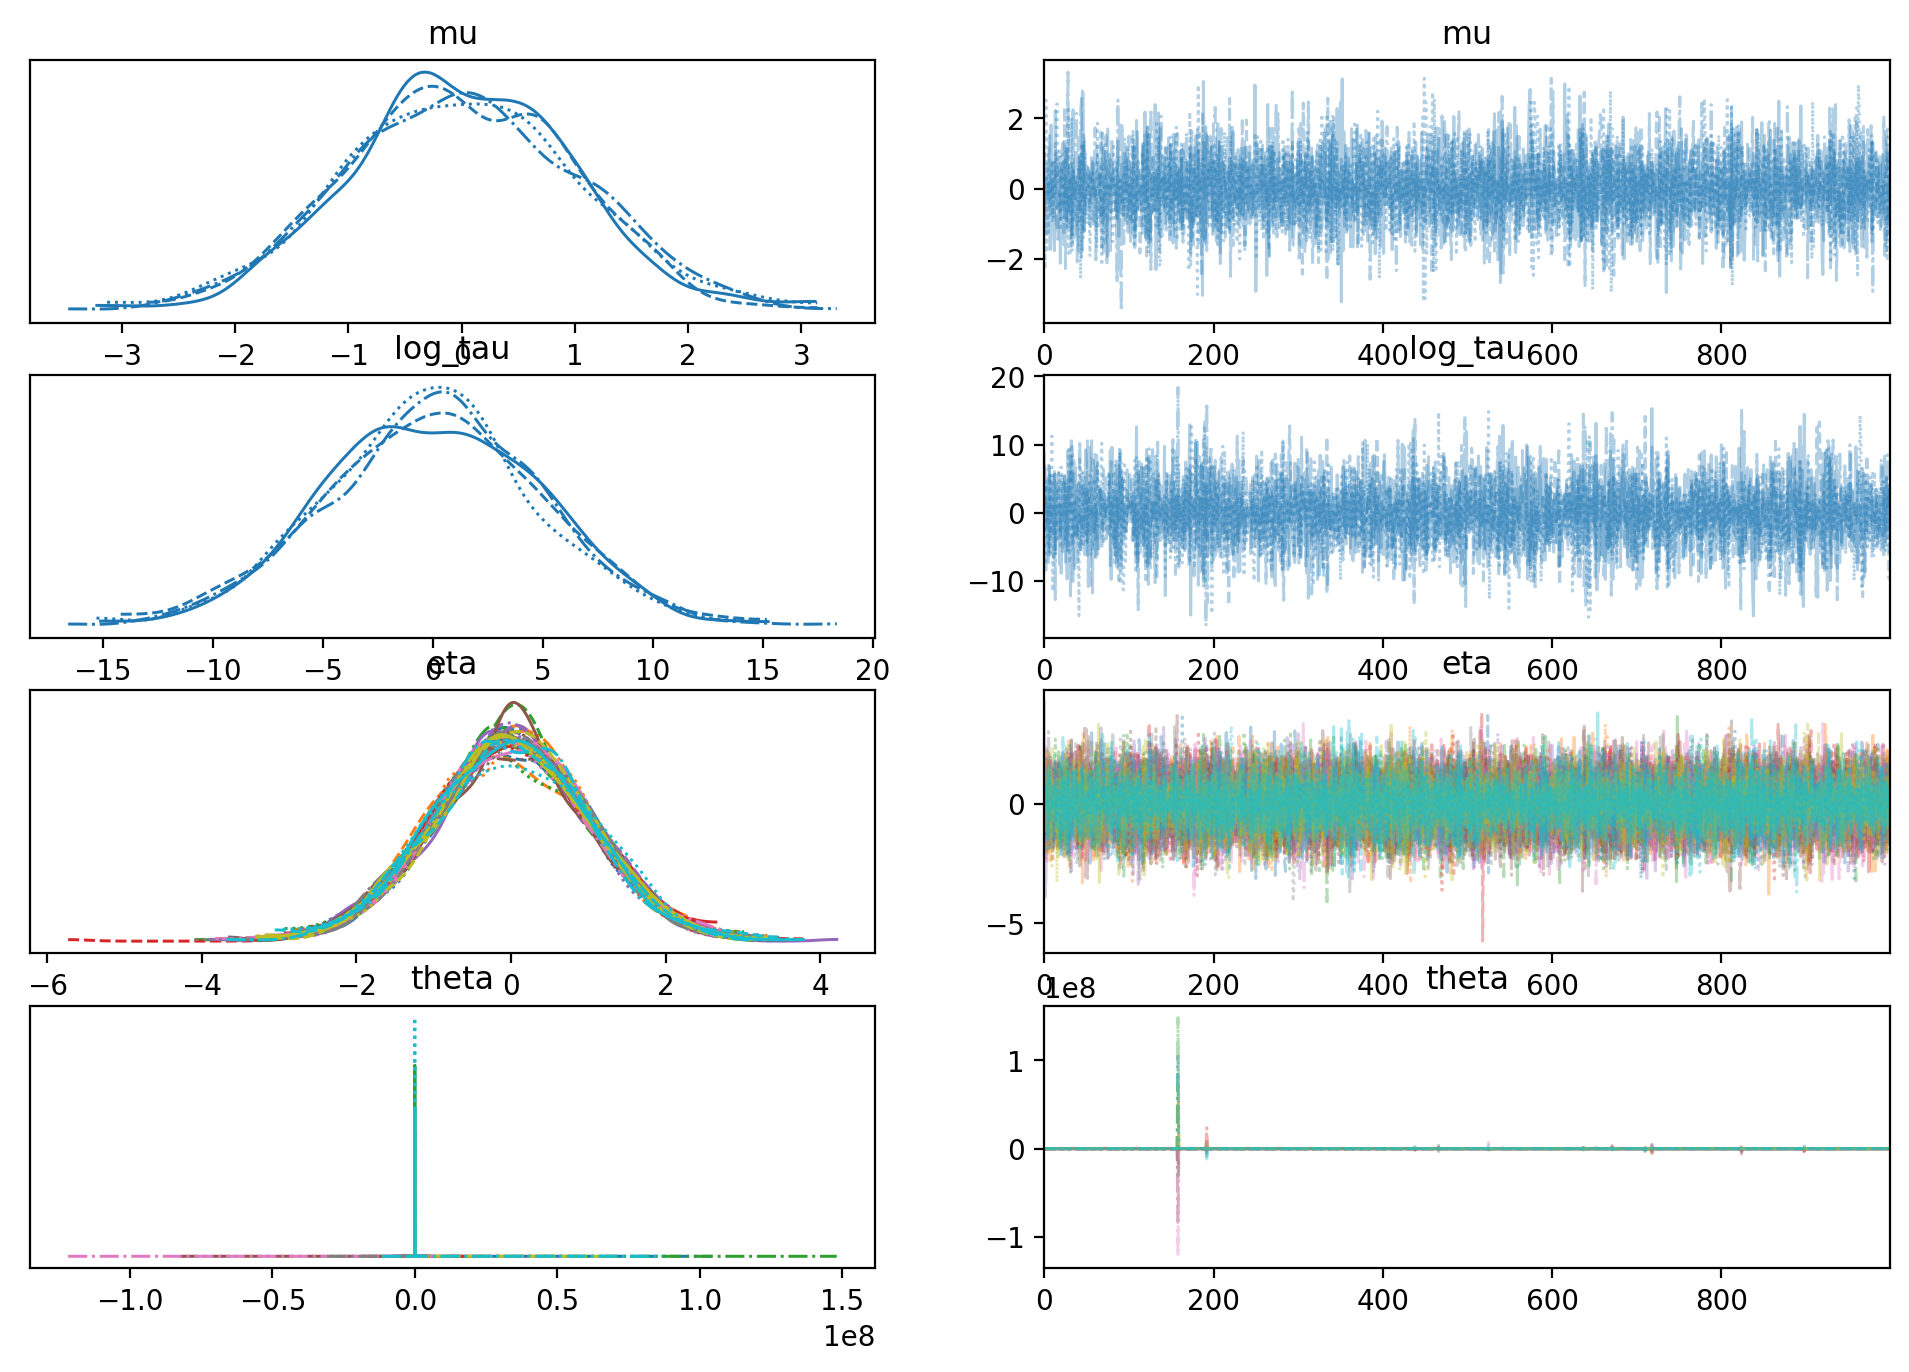

In [122]:
az.plot_trace(result_fun_ncp)

In [126]:
theta_1 = result_fun_ncp.stan_variable('theta')[:,0]

(-100.0, 100.0)

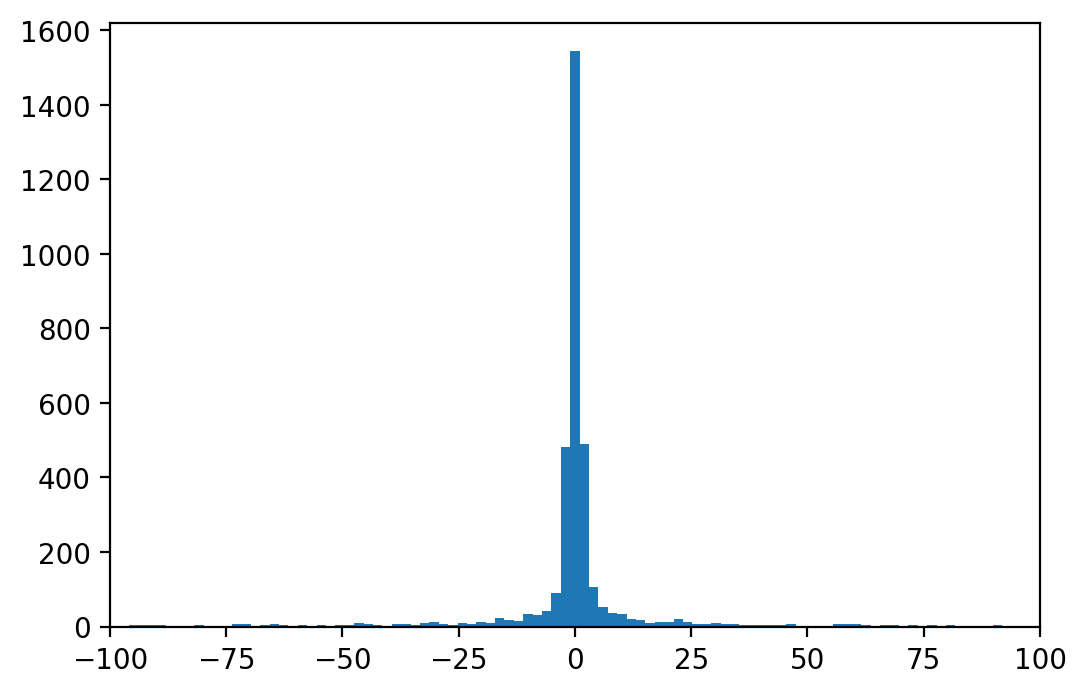

In [130]:
fig,ax = plt.subplots(1,1)
ax.hist(theta_1,bins = np.linspace(-100,100,100))
ax.set_xlim(-100,100)